In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import csv, warnings, math
import anchors
from poola import core as pool
from scipy.stats import ttest_ind
from scipy.interpolate import CubicSpline
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from adjustText import adjust_text

warnings.filterwarnings('ignore')
gpp.set_aesthetics(palette='Set2')


## Functions

In [2]:
## Data Cleaning  

def merge_dict_dfs(dictionary, merge_col = 'Gene Symbol', merge_how = 'outer', suffixes = ['_x', '_y']):
    '''
    Input: 1. dictionary: dictionary containing dataframes 
           2. merge_col: name of column on which dataframes will be merged (default = 'Gene Symbol')
           3. merge_how: type of merge (default = 'outer')
           4. suffixes: suffixes if two columns have the same name in dataframes being merged (default = ['_x','_y'])
            
    Output: merge1: merged dataframe 
    '''
    merge1 = pd.DataFrame()
    keys = []
    for df_name in dictionary.keys():
        keys.append(df_name)
    for i, df_name in enumerate(keys):
        current_df = dictionary[df_name]
        if (i+1 < (len(keys))): #stop before last df
            next_df_key = keys[i+1]
            next_df = dictionary[next_df_key]
            # merge dfs 
            if merge1.empty:  # if merged df does not already exist 
                merge1 = pd.merge(current_df, next_df, on = merge_col, how = merge_how, suffixes = suffixes)
                #print(merge1.columns)
            else: #otherwise merge next_df with previous merged df
                new_merge = pd.merge(merge1, next_df, on = merge_col, how = merge_how)
                merge1 = new_merge
        else: 
            continue
    return merge1


def clean_data(df, guide_col='Guide', library = False):
    '''
    Input: 1. df: Reads dataframe with guide_col and data columns 
           2. guide_col: Formatted as 'library_guide_gene' (e.g. 'HGLibA_00001_A1BG')
            

    Output: df_clean: Dataframe with columns 'Guide', 'Gene Symbol', 'Reads'
    '''
    df_clean = df.rename(columns={guide_col:'old_Guide'})
    library_list = []
    guide_list = []
    gene_list = []
    for i, row in enumerate(df_clean.loc[:,'old_Guide']):
        split_row = row.split('_')
        library = split_row[0]
        library_list.append(library)
        guide = split_row[1]
        guide_list.append(guide)
        gene = split_row[2]
        gene_list.append(gene)

    df_clean['Library'] = pd.Series(library_list)
    df_clean['Guide#'] = pd.Series(guide_list)
    df_clean['Guide'] = df_clean[['Library','Guide#']].apply(lambda x: '_'.join(x.dropna().values), axis=1)
    df_clean['Gene Symbol'] = pd.Series(gene_list)
    #df_clean['Reads'] = df.iloc[:,1].copy()
    #if not library:
    df_clean = df_clean.drop(['Library', 'Guide#','old_Guide'], axis = 1)
    
    # Reorder columns so Guide, Gene Symbol then data columns
    data_cols = [col for col in df.columns if col != guide_col]
    col_order = ['Guide','Gene Symbol'] + data_cols
    df_clean = df_clean[col_order]
    
    return df_clean

def get_grouped_controls(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotation df 
    2. control_name: list of string identifiers for controls 
    Outputs:
    1. grouped_controls: controls grouped into pseudogenes with 3 random controls from Library A and Library B, each
    '''
    for control in control_name:
        control_condition = (df['Gene Symbol'].str.contains(control))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        if len(set(control_rows['Gene Symbol'])) == 1:
            ungrouped_df = df.copy()
            # Give controls unique names before grouping 
            ungrouped_df.loc[control_condition, 'Gene Symbol'] = control + control_rows['Guide'] 
   
    LibA_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('LibA')]

    LibA_grouped_genes = pool.group_pseudogenes(LibA_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = control_name)

    LibB_ungrouped_genes = ungrouped_df[ungrouped_df['Guide'].str.contains('LibB')]
    LibB_grouped_genes = pool.group_pseudogenes(LibB_ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=3, gene_col='Gene Symbol', control_regex = control_name)

    grouped_controls = pd.concat([LibA_grouped_genes, LibB_grouped_genes])

    return grouped_controls

    
def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs: 
    1. df: data frame to which grouped pseudogene annotations will be merged 
    2. guide_mapping: guide-gene annotation data frame
    3. control_name: list containing substrings that identify controls 
    '''
    grouped_genes = get_grouped_controls(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

In [3]:
## QC functions 

def get_lognorm(df, cols = ['Reads'], new_col = ''):
    '''
    Inputs: 
    1. df: clean reads dataframe
    2. cols: list of names of column containing data used to calculate lognorm (default = ['Reads'])
    3. new_col: lognorm column name (optional) 
    Output: New dataframe with columns 'Gene Symbol', '[col]_Lognorm' (default = 'Reads_lognorm')
    '''
    df_lognorm = df.copy().drop(cols, axis = 1)
    for c in cols:
        df_lognorm[c+'_lognorm'] = pool.lognorm(df[c])
    return df_lognorm 

def calculate_lfc(lognorm_df, target_cols, ref_col = 'pDNA_lognorm'): 
    '''
    Inputs:
    1. lognorm_df: Dataframe containing reference and target lognorm columns 
    2. target_cols: List containing target column name(s) (lognorm column(s) for which log-fold change should be calculated)
    3. ref_col: Reference column name (lognorm column relative to which log-fold change should be calculated)(default ref_col = 'pDNA_lognorm')
    Outputs:
    1. lfc_df: Dataframe containing log-fold changes of target columns 
    '''
    #input df with lognorms + pDNA_lognorm
    lfc_df = pool.calculate_lfcs(lognorm_df=lognorm_df,ref_col='pDNA_lognorm', target_cols=target_cols)
    for col in target_cols: #rename log-fold change column so doesn't say "lognorm"
        lfc_col_name = col.replace('lognorm', 'lfc') 
        lfc_df = lfc_df.rename(columns = {col:lfc_col_name})
    return lfc_df

def get_controls(df, control_name = ['NonTargeting'], separate = True):
    '''
    Inputs:
    1. df: Dataframe with columns "Gene Symbol" and data 
    2. control_name: list containing substrings that identify controls 
    3. separate: determines whether to return non-targeting and intergenic controls separately (default = True)
    Outputs:
    1. control: Dataframe containing rows with Gene Symbols including control string specified in control_name 
    OR 2. control_dict: If separate and multiple control names, dictionary containing dataframes 
    OR 3. all_controls: If separate = False and multiple control names, concatenated dataframes in control_dict 
    '''
    if len(control_name) == 1:
        control = df[df['Gene Symbol'].str.contains(control_name[0])]
        return control
    else:
        control_dict = {}
        for i, ctrl in enumerate(control_name):
            control_dict[ctrl] = df[df['Gene Symbol'].str.contains(ctrl)]
        if separate: 
            return control_dict
        else:
            all_controls = pd.concat(list(control_dict.values()))
            return all_controls

def get_gene_sets():
    '''
    Outputs: essential and non-essential genes as defined by Hart et al. 
    '''
    ess_genes = pd.read_csv('../Data/External/Gene_sets_Hart/essential-genes.txt', sep='\t', header=None)
    ess_genes.columns = ['Gene Symbol']
    ess_genes['ess-val'] = [1]*len(ess_genes)
    non_ess = pd.read_csv('../Data/External/Gene_sets_Hart/non-essential-genes.txt', sep='\t', header=None)
    non_ess.columns = ['Gene Symbol']
    non_ess['non-ess-val'] = [1]*len(non_ess)
    return ess_genes, non_ess

def merge_gene_sets(df):
    '''
    Input:
    1. df: data frame from which ROC-AUC is being calculated 
    Output:
    1. df: data frame with binary indicators for essential and non-essential genes 
    '''
    ess_genes, non_ess = get_gene_sets()
    df = pd.merge(df, ess_genes, on='Gene Symbol', how='left')
    df['ess-val'] = df['ess-val'].fillna(0)
    df = pd.merge(df, non_ess, on='Gene Symbol', how='left')
    df['non-ess-val'] = df['non-ess-val'].fillna(0)
    return df

def get_roc_auc(df, col):
    '''
    Inputs:
    1. df: data frame from which ROC-AUC is being calculated 
    2. col: column with data for which ROC-AUC is being calculated
    Outputs: 
    1. roc_auc: AUC value where true positives are essential genes and false positives are non-essential
    2. roc_df: dataframe used to plot ROC-AUC curve 
    '''
    df = df.sort_values(by=col)
    df['ess_cumsum'] = np.cumsum(df['ess-val'])
    df['non_ess_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['non_ess_cumsum']/(df['non_ess_cumsum'].iloc[-1])
    df['tpr'] = df['ess_cumsum']/(df['ess_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

def convertdftofloat(df):
    '''
    Converts df data column type into float 
    Input:
    1. df: data frame
    '''
    for col in df.columns[1:]:
        df[col] = df[col].astype(float) #convert dtype to float 
    return df

def new_rank_df(df, col = None, drop_col = True, ascending = False): #df with 2 cols "Gene Symbol" and scoring metric  
    '''
    Inputs:
    1. df: initial dataframe containing data that will be ranked
    2. col: column with data that will be ranked
    3. drop_col: bool indicating whether original data columns will be dropped in output df (default: True)
    4. ascending: direction of ranking (default: False)
    Output:
    rank_df: dataframe with ranked assigned to Gene Symbol 
    '''
    if not col:
        col = df.columns[1] #score column
    rank_df = pd.DataFrame()
    #print(col)
    rank_df = df.copy()[['Gene Symbol', col]]
    rank_df = df.sort_values(by = col, ascending = ascending).reset_index(drop = True) #column in descending order by default
    rank_col_name = 'Rank_' + col
    rank_df[rank_col_name] = rank_df.index + 1
    if drop_col: 
        rank_df = rank_df.copy().drop(col, axis = 1)
    rank_df = convertdftofloat(rank_df)
    return rank_df


In [4]:
## Plotting functions
def pair_cols(df, initial_id = 'control', res_id = 'MOI', sep = '_', col_type = 'lfc'): #if more than one set of initial/resistant pop pairs, sharex = True, store pairs in list
    '''
    Inputs: 
    1. df: Dataframe containing log-fold change values and gene symbols 
    2. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    3. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    4. sep: character separator in column name 
    3. col_type: string in names of columns containing data to be plotted (default: 'lfc')
    Outputs: 
    1. sharex: if number of pairs greater than 1 indicating multiple subplots
    2. pairs: pairs of initial and resistant populations as list of lists 
    '''
    cols = [col for col in df.columns if col_type in col]
    pairs = [] #list of lists: ini/res pop pairs
    sharex = False
    if len(cols) > 2: #if more than one set of initial/resistant pop pairs 
        
        for index, col in enumerate(cols):
            pair = []
            if initial_id in col: #find corresponding resistant pop
                pair.append(col)
                split_col = col.split(sep)
                ini_index = split_col.index(initial_id)
                res_col_string = ' '.join(split_col[:ini_index])
                res_pop = [col for col in cols if res_id in col]

                for col in res_pop:
                    pair.append(col)
                    
                pairs.append(pair) #add to list of pairs (list of lists)
        if len(pairs) > 1:
            sharex = True # set sharex parameter for subplot 
        return sharex, pairs

    else: #if only one pair of initial/resistant pops
        sharex = False
        pairs.append(cols)
        return sharex, pairs

    
def lfc_dist_plot(chip_lfc, initial_id = 'control', res_id = 'MOI', ref_map = None, filename = '', figsize = (6,4)): #kde plots of population distribution (initial, resistant)
    '''
    Inputs: 
        1. chip_lfc: Dataframe containing log-fold change values and gene symbols 
        Option 1:
        2. initial_id: substring in names of column containing log-fold changes of uninfected population
        3. res_id: substring in names of column containing log-fold changes of infected population
        Option 2:
        4. ref_map: Dataframe with two columns: 
                    -'initial': (string) name of column containing log-fold changes of uninfected population
                    -'resistant': list name(s) of column(s) containing log-fold changes of infected population
                        --> if there's more than one resistant population corresponding to the same initial population,
                            store as list in same cell 
        _____
        5. filename: string for file name when saving figure 
        6. figsize: default (6,4)
                            
    Outputs: kde plots of population distribution (initial, resistant)
    '''
        
    if not ref_map:
        sharex, lfc_pairs = pair_cols(chip_lfc, initial_id = initial_id, res_id = res_id)

    fig, ax = plt.subplots(nrows = len(lfc_pairs), ncols = 1, sharex = sharex, figsize = figsize)
    
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs):
        
        for l, c1 in enumerate(c):
            #title ex. Calu-3 Calabrese A screen 1, (k+1 = screen #)
            if not filename:
                title = ' '.join(c1.split(' ')[:3]) + ' (populations)'
            else:
                title = filename
            if l==0:
                label1 = c1
            else:
                label1 = c1
                
            if sharex: #if multiple axes, ax = ax[i]
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax[i], legend=True)
                t = ax[i].set_xlabel('Log-fold changes') 
                t = ax[i].set_title(title)
            else: 
                chip_lfc[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label=label1, ax=ax, legend=True)
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1
        sns.despine()   
    filepath = '../Figures/' + filename + '_popdist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    
#Control distributions
def control_dist_plot(chip_lfc, control_name = ['NonTargeting'], initial_id = 'control', res_id = 'MOI', filename = '', figsize = (6,4)): 
    '''
    Inputs: 
    1. chip_lfc: annotated lfc data frame
    2. control_name: list containing strings identifying controls 
    3. initial_id: string identifying initial column names (default: 'control'), only used if multiple subplots
    4. res_id: string identifying resistant column names (default: 'MOI'), only used if multiple subplots
    5. filename: filename for saving figure
    6. figsize: default (6, 4)
    Outputs: kde plots of control distributions (initial, resistant)
    
    '''
    sharex, lfc_pairs = pair_cols(chip_lfc, initial_id= initial_id, res_id=res_id)
    controls = get_controls(chip_lfc, control_name)
    nrows = len(lfc_pairs)
    
    fig, ax = plt.subplots(nrows = nrows, ncols = 1, sharex = sharex, figsize = figsize)
    i = 0 # ax index if have to plot multiple axes
    for k,c in enumerate(lfc_pairs): # k=screen, c=ini, res pair 
        for l, c1 in enumerate(c): # l = ini or res, c1 = pop label 
            title = c1 + ' (controls)'
            pop_label = c1.split(' ')[0] #labels 'initial' or 'resistant'
            #Plot same screen on same subplot 
            if sharex: #if multiple axes, ax = ax[i]
                controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Nontargeting ('+pop_label+')', ax=ax[i], legend=True)
                ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax[i].set_xlabel('Log-fold changes')
                t = ax[i].set_title(title)
            else: 
                controls[c1].plot(kind='kde',c=sns.color_palette('Set2')[l],label='Nontargeting ('+pop_label+')', ax=ax, legend=True)
                ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                sns.despine()
                t = ax.set_xlabel('Log-fold changes')
                t = ax.set_title(title)
        i+=1 #switch to next subplot for next screen

        sns.despine()
    #filename = '_'.join(screen) #get screen name and library and join with _
    filepath = '../Figures/' + filename + '_controldist.png'
    print(filepath)
    fig.savefig(filepath, bbox_inches = 'tight')
    

In [5]:
def run_guide_residuals(lfc_df):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

#Modify so combine on gene_col only and not condition_col

import statsmodels
from scipy import stats
from anchors.score import aggregate_guide_residuals

def aggregate_guide_residuals(mapped_guide_residuals, gene_col, construct_col):
    """Combine guide residuals at the gene level
    Parameters
    ----------
    mapped_guide_residuals: DataFrame
        Guide residuals mapped to genes
    gene_col: str
        Name of column with genes
    construct_col: str
        Name of column with constructs
    Returns
    -------
    DataFrame
        Gene summarized residuals
    """
    gene_residuals = (mapped_guide_residuals.groupby([gene_col])
                      .agg(sum_z=('residual_z', 'sum'),
                           guides=(construct_col, 'nunique'),
                           avg_lfc=('lfc', 'mean'),
                           avg_lfc_reference=('lfc_reference', 'mean'))
                      .reset_index())
    gene_residuals['residual_zscore'] = gene_residuals['sum_z'] / np.sqrt(gene_residuals['guides'])
    gene_residuals = gene_residuals.drop('sum_z', axis=1)
    gene_residuals['p_value'] = stats.norm.sf(abs(gene_residuals.residual_zscore)) * 2
    gene_residuals['fdr_bh'] = (gene_residuals.groupby('Gene Symbol')
                                .p_value
                                .transform(lambda x: statsmodels.stats.multitest.multipletests(x, method='fdr_bh')[1]))
    return gene_residuals

def get_gene_residuals(guide_residuals, guide_mapping):
    """Combine guide residuals at the gene level
    Parameters
    ----------
    guide_residuals: DataFrame
        Results from get_guide_residuals
    guide_mapping: DataFrame
        Mapping between guides and genes. The
        first column should identify sgRNAs and the second column should identify gene symbols
    Returns
    -------
    """
    anchors.score.check_gene_inputs(guide_residuals, guide_mapping)
    mapping_construct_col = guide_mapping.columns[0]
    mapping_gene_col = guide_mapping.columns[1]
    residual_construct_col = guide_residuals.columns[0]
    mapped_guide_residuals = anchors.score.merge_residual_mapping(guide_residuals, guide_mapping, residual_construct_col,
                                                    mapping_construct_col)
    gene_residuals = aggregate_guide_residuals(mapped_guide_residuals, mapping_gene_col, residual_construct_col)
    return gene_residuals

def format_gene_residuals(df, guide_min = 4, guide_max = 8, ascending = False):
    '''
    Inputs: 
    1. df: gene_residuals output df 
    2. guide_min: min number of guides per gene to filter df
    3. guide_max: max number of guides per gene to filter df
    4. ascending: direction to sort df 
    Outputs:
    1. df_z: dataframe with the following columns: 
            -Gene Symbol
            -residual_zscore: residual_zscores averaged across conditions 
            -Rank_residual_zscore: 
    '''
    df = df[(df['guides']>=guide_min) & (df['guides']<=guide_max)]
    if 'condition' in df.columns: 
        conditions = list(set(df.loc[:, 'condition']))
        print(conditions)
        if len(conditions) > 1:
            df_z = df[['condition', 'Gene Symbol', 'residual_zscore']]
            condition_dict = {}
            for i, c in enumerate(conditions):
                print(c)
                condition_dict[c] = df_z[df_z['condition'] == c]
            #print(condition_dict) 
            merged_df_z = merge_dict_dfs(condition_dict, suffixes=['_37C', '_33C'])
            merged_df_z['residual_zscore_avg'] = merged_df_z.mean(axis = 1)
            #condition_cols = [col for col in merged_df_z.columns if 'condition' in col]
            df_z = merged_df_z.copy()[['Gene Symbol', 'residual_zscore_avg']]
            df_z = new_rank_df(df_z, 'residual_zscore_avg', drop_col=False, ascending = ascending)
    else:
        df_z = df[['Gene Symbol', 'residual_zscore']]
        df_z = new_rank_df(df_z, 'residual_zscore', drop_col=False, ascending=ascending)

    return df_z





## Data Summary

* Daniloski et al.
* Cell line: A549 (overexpressing ACE2)
* Library: GeCKOv2

In [6]:
#Read counts
pDNA_reads_raw = pd.read_csv('../Data/Reads/Sanjana/GSM4796722_GeckoV2plasmid.counts.txt', sep = '\t', header = None)
control_reads_raw = pd.read_csv('../Data/Reads/Sanjana/GSM4796723_PreInfection.counts.txt', sep = '\t', header = None)
MOI1_reads_raw = pd.read_csv('../Data/Reads/Sanjana/GSM4796724_SARS2MOI001.counts.txt', sep = '\t', header = None)
MOI3_reads_raw = pd.read_csv('../Data/Reads/Sanjana/GSM4796725_SARS2MOI03.counts.txt', sep = '\t', header = None)

In [7]:
#Reformat data tables
#column 0 = 'HGLibA_00001_A1BG' -> 'library_guide_gene', column 1 = read counts
reads_raw_dict = {'pDNA':pDNA_reads_raw, 'control': control_reads_raw, 'MOI1': MOI1_reads_raw, 'MOI3':MOI3_reads_raw}
# Merge dataframes in dictionary into single data frame 
all_reads_raw = merge_dict_dfs(reads_raw_dict, merge_col=0)
# Rename columns
all_reads_raw.columns = ['Guide'] + list(reads_raw_dict.keys())
# Reformat Guide column into Guide column with 'library_guide#' and Gene Symbol column with gene name 
all_reads_clean = clean_data(all_reads_raw)

# Group controls into pseudo genes 
guide_mapping = all_reads_clean[['Guide', 'Gene Symbol']]
reads = match_pseudogenes(all_reads_clean, guide_mapping, control_name=['NonTargeting'])

reads

,Guide,Gene Symbol,pDNA,control,MOI1,MOI3
0,HGLibA_00001,A1BG,467.0,296.0,139.0,199.0
1,HGLibA_00002,A1BG,417.0,269.0,782.0,356.0
2,HGLibA_00003,A1BG,981.0,942.0,1641.0,1563.0
3,HGLibA_00004,A1CF,170.0,220.0,170.0,275.0
4,HGLibA_00005,A1CF,599.0,418.0,402.0,344.0
...,...,...,...,...,...,...
123399,HGLibB_58025,NonTargeting_181,694.0,398.0,40.0,226.0
123400,HGLibB_58026,NonTargeting_63,1676.0,2186.0,1914.0,1938.0
123401,HGLibB_58027,NonTargeting_154,460.0,378.0,187.0,406.0
123402,HGLibB_58028,NonTargeting_112,648.0,739.0,851.0,586.0


In [8]:
#Calculate lognorm

cols = reads.columns[2:].to_list() #reads columns are 3rd and 4th in df
lognorms = get_lognorm(reads.dropna(), cols = cols)
lognorms


,Guide,Gene Symbol,pDNA_lognorm,control_lognorm,MOI1_lognorm,MOI3_lognorm
0,HGLibA_00001,A1BG,2.966246,2.500066,1.673673,2.199463
1,HGLibA_00002,A1BG,2.824838,2.387448,3.735758,2.892941
2,HGLibA_00003,A1BG,3.936957,3.983764,4.747262,4.868937
3,HGLibA_00004,A1CF,1.799434,2.157486,1.879209,2.576599
4,HGLibA_00005,A1CF,3.284114,2.921550,2.874682,2.850232
...,...,...,...,...,...,...
123398,HGLibB_58024,NonTargeting_253,3.834426,1.398505,1.347218,1.750734
123399,HGLibB_58025,NonTargeting_181,3.476077,2.860353,0.705129,2.344996
123400,HGLibB_58026,NonTargeting_63,4.670054,5.145409,4.961595,5.169602
123401,HGLibB_58027,NonTargeting_154,2.947264,2.796444,1.980613,3.058423


## Quality Control

### Population Distributions

../Figures/A549_GeCKOv2_popdist.png


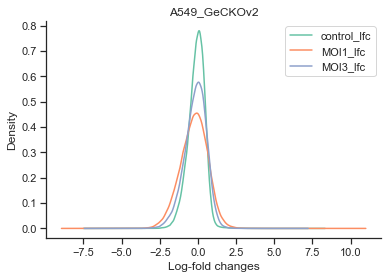

In [9]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = calculate_lfc(lognorms,target_cols)
#Plot population distributions of log-fold changes 
lfc_dist_plot(pDNA_lfc, filename = 'A549_GeCKOv2')

### Control Distributions

../Figures/A549_GeCKOv2_controldist.png


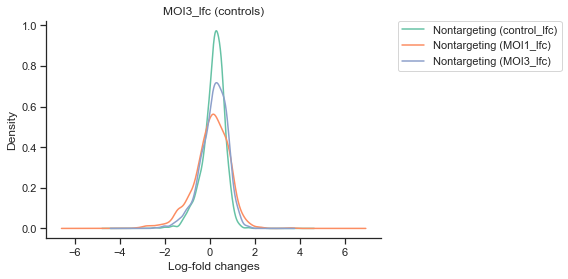

In [10]:
#Plot control distributions (non-targeting) of log-fold changes 
control_dist_plot(pDNA_lfc, filename='A549_GeCKOv2')

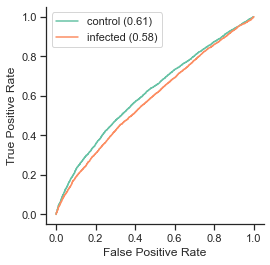

In [11]:
#Plot ROC-AUC
#for key, df in control_lfc_df_dict.items():
df = pDNA_lfc
df_ann = merge_gene_sets(df)
ctrl_idx = df_ann.columns.get_loc("control_lfc")
res_col = df_ann.columns[ctrl_idx+1]
roc_auc_ctrl, roc_df_ctrl = get_roc_auc(df_ann, 'control_lfc')
roc_auc_res, roc_df_res = get_roc_auc(df_ann, res_col)
fig, ax = plt.subplots()
g = plt.plot(roc_df_ctrl.False_Positive_Rate, roc_df_ctrl.True_Positive_Rate, label = 'control ('+str(np.round(roc_auc_ctrl,2))+')')
g = plt.plot(roc_df_res.False_Positive_Rate, roc_df_res.True_Positive_Rate, label = 'infected ('+str(np.round(roc_auc_res,2))+')')
t = plt.xlabel('False Positive Rate')
t = plt.ylabel('True Positive Rate')
sns.despine()
ax.set_aspect('equal')
t = plt.legend()
fig.savefig('../Figures/Sanjana_ROC-AUC.png', dpi=1000)
#break


## Gene-level analysis

### Residual z-scores

In [12]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()

guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df)

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)
gene_residuals

   modified  unperturbed
0  MOI1_lfc  control_lfc
1  MOI3_lfc  control_lfc


,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,MOI1_lfc,A1BG,6,0.483889,0.093881,1.839807,0.065797,0.882099
1,MOI1_lfc,A1CF,6,-0.223977,-0.238506,0.500633,0.616629,0.988931
2,MOI1_lfc,A2M,6,-0.046903,-0.122739,0.594756,0.552006,0.988931
3,MOI1_lfc,A2ML1,6,-0.380949,-0.604698,0.713594,0.475479,0.982670
4,MOI1_lfc,A3GALT2,6,0.174463,-0.017858,1.170465,0.241814,0.953752
...,...,...,...,...,...,...,...,...
42447,MOI3_lfc,hsa-mir-95,4,0.355688,-0.067872,1.531184,0.125724,0.856787
42448,MOI3_lfc,hsa-mir-96,4,0.034399,0.436245,-0.506850,0.612260,0.976538
42449,MOI3_lfc,hsa-mir-98,4,-0.732801,-0.473712,-1.000523,0.317058,0.936176
42450,MOI3_lfc,hsa-mir-99a,4,-0.216777,0.361183,-1.196399,0.231541,0.914700


In [13]:
gene_residual_sheet= format_gene_residuals(gene_residuals, guide_min = 5, guide_max = 7)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')
guide_residual_sheet

['MOI1_lfc', 'MOI3_lfc']
MOI1_lfc
MOI3_lfc


,Guide,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,HGLibA_00001,A1BG,MOI1_lfc,-0.795064,-0.991310,control_lfc,-1.292573,-0.466180
1,HGLibA_00001,A1BG,MOI3_lfc,-0.361801,-0.588971,control_lfc,-0.766783,-0.466180
2,HGLibA_00002,A1BG,MOI1_lfc,1.385478,1.727455,control_lfc,0.910920,-0.437390
3,HGLibA_00002,A1BG,MOI3_lfc,0.450344,0.733107,control_lfc,0.068103,-0.437390
4,HGLibA_00003,A1BG,MOI1_lfc,0.918496,1.145209,control_lfc,0.810305,0.046807
...,...,...,...,...,...,...,...,...
238649,HGLibB_58026,NonTargeting_63,MOI3_lfc,0.278845,0.453927,control_lfc,0.499548,0.475354
238650,HGLibB_58027,NonTargeting_154,MOI1_lfc,-0.715452,-0.892048,control_lfc,-0.966651,-0.150820
238651,HGLibB_58027,NonTargeting_154,MOI3_lfc,0.271816,0.442485,control_lfc,0.111159,-0.150820
238652,HGLibB_58028,NonTargeting_112,MOI1_lfc,0.431195,0.537627,control_lfc,0.462632,0.272136


In [14]:
with pd.ExcelWriter('../Data/Processed/GEO_submission/A549_GeCKOv2_Sanjana.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='A549_GeCKOv2_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='A549_GeCKOv2_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='A549_GeCKOv2_genomewide_mapping', index =False)
    

In [15]:
with pd.ExcelWriter('../Data/Processed/Individual_screens/A549_GeCKOv2_Sanjana_v2.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)